https://tombolton.io/2018/08/25/softmax-back-propagation-solved-i-think/

In [ ]:
!pip install nnfs

In [ ]:
from nnfs.datasets import spiral_data
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_blobs
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

# Network Buiding Blocks

In [ ]:
class Layer_Linear():
  def __init__(self, n_inputs, n_outputs):
    self.weights = np.random.randn(n_inputs, n_outputs)
    self.biases = np.zeros(n_outputs)

  def forward(self, X):
    self.inputs = X
    return np.matmul(X, self.weights) + self.biases

  def backward(self, gradient):
    self.d_w = np.matmul(self.inputs.T, gradient)
    self.d_b = np.sum(gradient, axis=0)
    self.d_a = np.matmul(self.weights, gradient.T)

  def optimize(self, learning_rate):
    self.weights -= learning_rate * self.d_w
    self.biases -= learning_rate * self.d_b


class Activation_Relu():
  def __init__(self):
    pass

  def forward(self, X):
    self.input = X
    return np.clip(np.where(X > 0, X, 0), 0, 3)

  def backward(self, gradient):
    self.d_z = np.where(self.input > 0, 1, 0) * gradient.T


class Activation_Softmax():
  def __init__(self):
    pass

  def forward(self, X):
    self.inputs = X
    exp_X = np.exp(X)
    self.outputs = exp_X / np.sum(exp_X, axis=1).reshape(-1, 1)
    return self.outputs

  def backward(self, y_true, d_loss): # dL/dS * dS/dZ
    batch_size = len(self.inputs)
    l = len(self.inputs[0])
    derivatives = np.zeros((batch_size, l))
    for i in range(batch_size):
      k = y_true[i]
      for j in range(l):
        if j == k:
          derivatives[i, j] = self.outputs[i, j] * (1 - self.outputs[i, k])
        else:
          derivatives[i, j] = -self.outputs[i, j] * self.outputs[i, k]
    self.d_s = derivatives * d_loss


class Loss_CategoricallCrossEntropy():
  def __init__(self):
    pass

  def forward(self, y_true, y_pred):
    self.losses = np.array([-np.log(np.clip(y_p[y_t], 1e-9, 1)) for y_t, y_p in zip(y_true, y_pred)])
    return np.mean(self.losses)

  def backward(self, y_true, y_pred): # dL/dS
    return np.array([-1/y_p[y_t] for y_t, y_p in zip(y_true, y_pred)]).reshape(-1, 1)


class Loss_MSE():
  def __init__(self):
    pass

  def forward(self, y_true, y_pred):
    self.error = y_pred - y_true
    self.losses = self.error ** 2
    return np.mean(self.losses)

  def backward(self):
    return self.error

# Classification

In [ ]:
class NeuralNetwork():
  def __init__(self, input_size, hidden_size, output_size):
    self.linear1 = Layer_Linear(input_size, hidden_size)
    self.relu1 = Activation_Relu()
    self.linear2 = Layer_Linear(hidden_size, hidden_size)
    self.relu2 = Activation_Relu()
    self.linear3 = Layer_Linear(hidden_size, output_size)
    self.softmax = Activation_Softmax()

  def forward(self, X):
    self.z1 = self.linear1.forward(X)
    self.a1 = self.relu1.forward(self.z1)
    self.z2 = self.linear2.forward(self.a1)
    self.a2 = self.relu2.forward(self.z2)
    self.z3 = self.linear3.forward(self.a2)
    self.output = self.softmax.forward(self.z3)

  def backward(self, y_true, d_loss):
    self.softmax.backward(y_true, d_loss)
    self.linear3.backward(self.softmax.d_s)
    self.relu2.backward(self.linear3.d_a)
    self.linear2.backward(self.relu2.d_z)
    self.relu1.backward(self.linear2.d_a)
    self.linear1.backward(self.relu1.d_z)

  def optimize(self, learning_rate):
    self.momentum1 = self.linear1.optimize(learning_rate)
    self.momentum2 = self.linear2.optimize(learning_rate)
    self.momentum3 = self.linear3.optimize(learning_rate)

In [ ]:
def accuracy(y_true, y_pred):
  return np.sum(y_true == y_pred) / len(y_true)

## Spiral Data

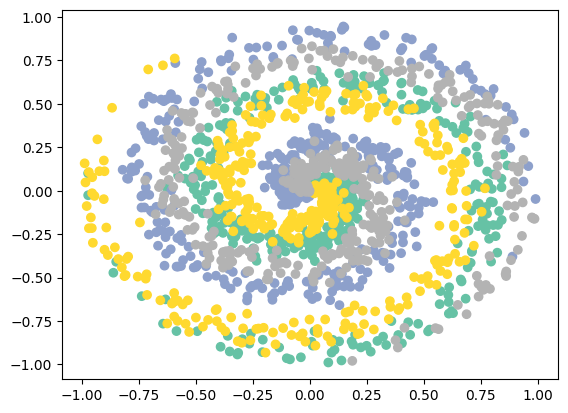

In [ ]:
X, y = spiral_data(400, 4)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Set2");

In [ ]:
model = NeuralNetwork(2, 300, 4)
loss_fn = Loss_CategoricallCrossEntropy()

Epoch: 1 Accuracy: 27.375%   Loss: 12.3959


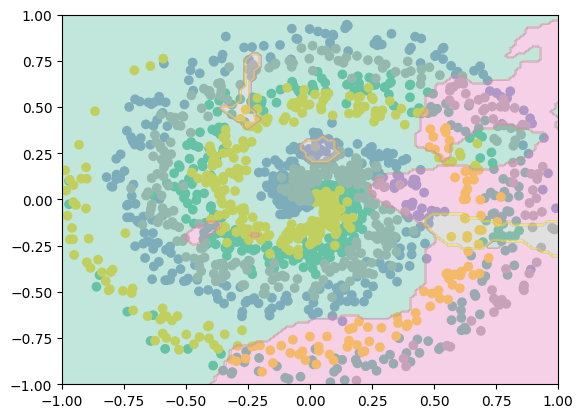

Epoch: 201 Accuracy: 71.562%   Loss: 0.6912


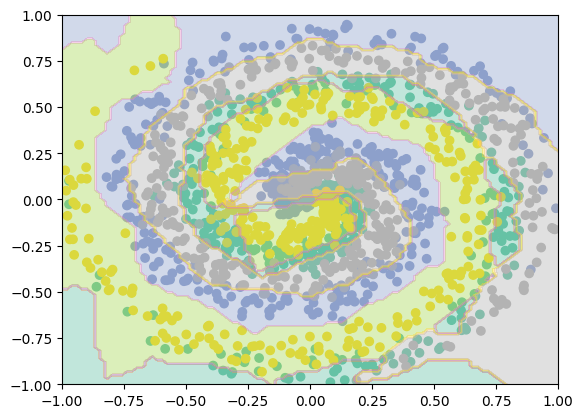

Epoch: 401 Accuracy: 74.125%   Loss: 0.5905


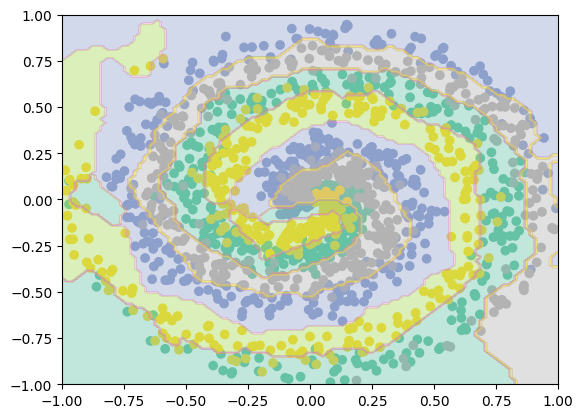

Epoch: 601 Accuracy: 76.938%   Loss: 0.5223


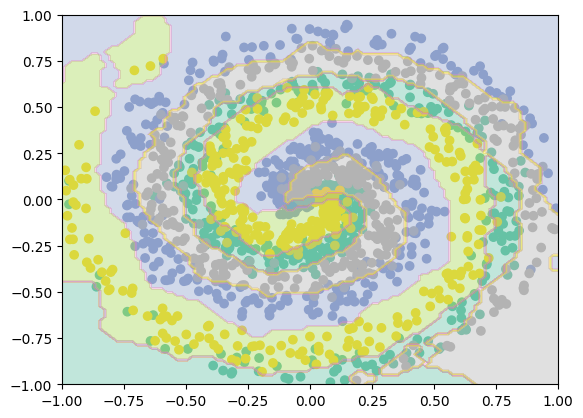

Epoch: 801 Accuracy: 79.125%   Loss: 0.5067


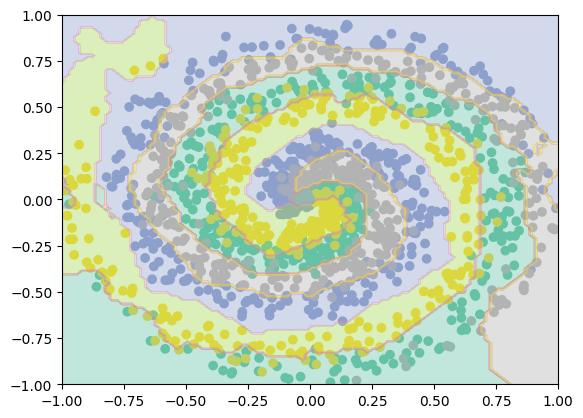

Epoch: 1001 Accuracy: 81.75%   Loss: 0.4557


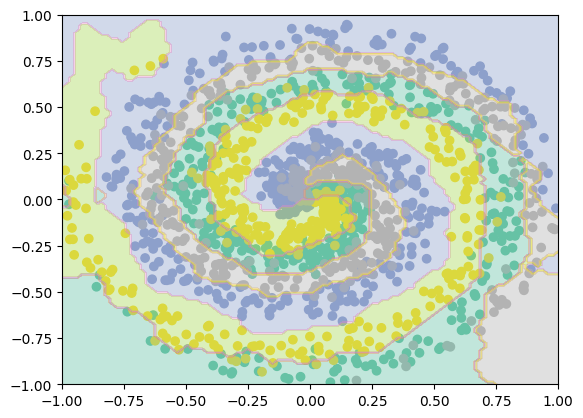

Epoch: 1201 Accuracy: 80.312%   Loss: 0.465


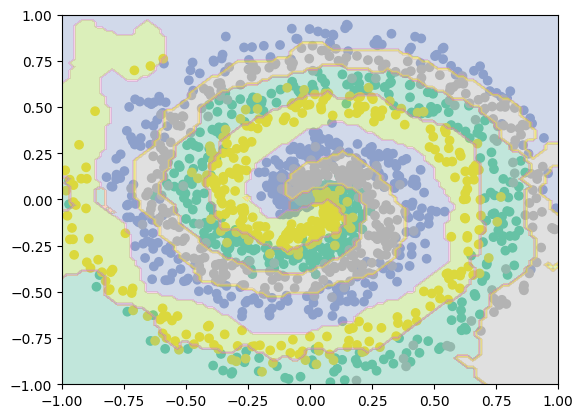

Epoch: 1401 Accuracy: 80.5%   Loss: 0.4531


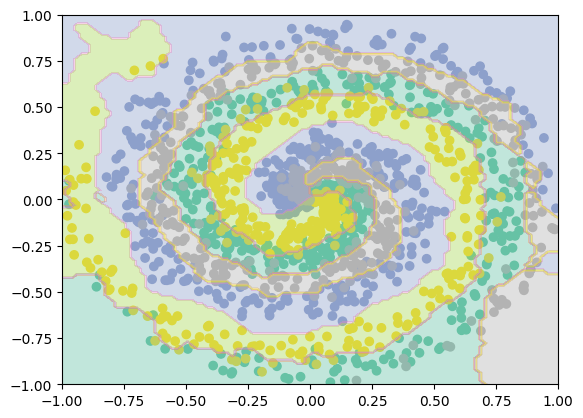

Epoch: 1601 Accuracy: 80.812%   Loss: 0.4275


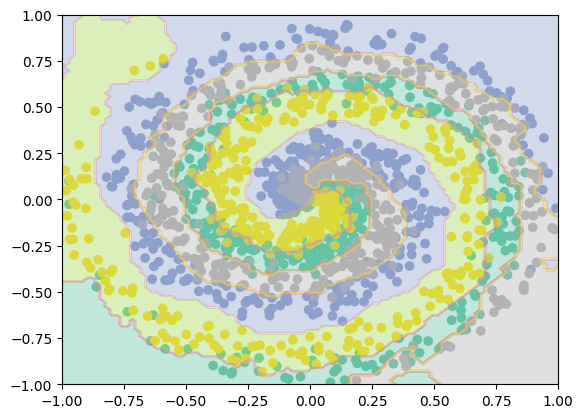

Epoch: 1801 Accuracy: 80.562%   Loss: 0.425


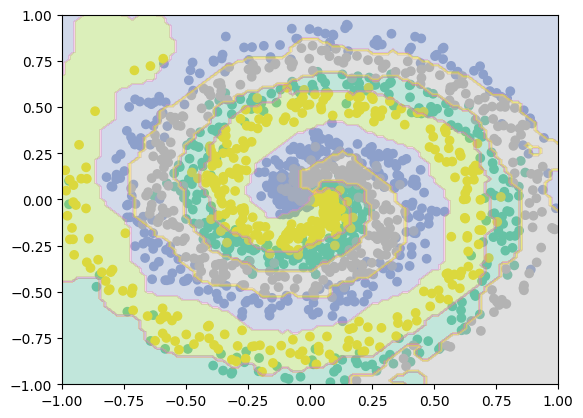

Epoch: 2001 Accuracy: 82.688%   Loss: 0.403


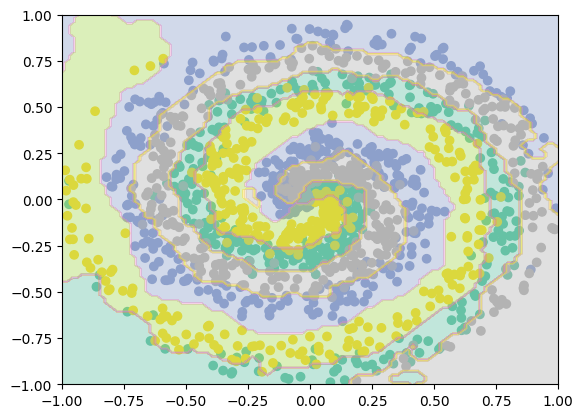

In [ ]:
for i in range(2001):
  model.forward(X)
  y_pred = model.output
  loss = loss_fn.forward(y, y_pred)
  d_loss = loss_fn.backward(y, y_pred)
  model.backward(y, d_loss)
  model.optimize(0.0001)

  if i % 200 == 0:
    model.forward(X)
    y_pred = model.output
    loss = loss_fn.forward(y, y_pred)
    train_accuracy = accuracy(y, np.argmax(y_pred, axis=1))
    print(f"Epoch: {i + 1} Accuracy: {round(train_accuracy * 100, 3)}%   Loss: {round(loss, 4)}")
    xx, yy = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
    X_test = np.c_[xx.ravel(), yy.ravel()]
    model.forward(X_test)
    y_pred = np.argmax(model.output, axis=1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Set2");
    plt.contourf(xx, yy, y_pred.reshape(xx.shape), cmap="Set2", alpha=0.4);
    plt.show()

## MNIST

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255
X_test = X_test / 255
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=50000)

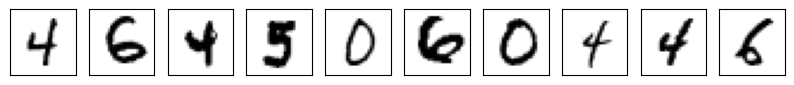

In [ ]:
fig, axis = plt.subplots(1, 10, figsize=[10, 1])
for img, ax in zip(X_train[:10], axis):
  ax.imshow(img, cmap="binary")
  ax.set_yticks([])
  ax.set_xticks([])

In [ ]:
def flatten(X):
  return X.reshape(X.shape[0], 784)

In [ ]:
model = NeuralNetwork(784, 500, 10)
loss_fn = Loss_CategoricallCrossEntropy()
batch_size = 1000

In [ ]:
for i in range(101):
  for j in range(len(X_train) // batch_size):
    indices = np.random.choice(range(len(X_train)), size=batch_size, replace=False)
    X = X_train[indices]
    y = y_train[indices]
    model.forward(flatten(X))
    y_pred = model.output
    loss = loss_fn.forward(y, y_pred)
    d_loss = loss_fn.backward(y, y_pred)
    model.backward(y, d_loss)
    model.optimize(0.0001)

  if i % 10 == 0:
    model.forward(flatten(X_train))
    y_pred = model.output
    train_loss = loss_fn.forward(y_train, y_pred)
    train_accuracy = accuracy(y_train, np.argmax(y_pred, axis=1))

    model.forward(flatten(X_val))
    y_pred = model.output
    val_loss = loss_fn.forward(y_val, y_pred)
    val_accuracy = accuracy(y_val, np.argmax(y_pred, axis=1))

    print(f"Epoch: {i + 1} Train Accuracy: {round(train_accuracy * 100, 3)}%  Train Loss: {round(train_loss, 3)}    Validation Accuracy: {round(val_accuracy * 100, 3)}%  Validation Loss: {round(val_loss, 3)}")

Epoch: 1 Train Accuracy: 80.788%  Train Loss: 2.6    Validation Accuracy: 79.51%  Validation Loss: 2.797
Epoch: 11 Train Accuracy: 91.244%  Train Loss: 0.688    Validation Accuracy: 88.61%  Validation Loss: 1.086
Epoch: 21 Train Accuracy: 91.452%  Train Loss: 0.456    Validation Accuracy: 88.74%  Validation Loss: 0.817
Epoch: 31 Train Accuracy: 92.342%  Train Loss: 0.332    Validation Accuracy: 89.08%  Validation Loss: 0.644
Epoch: 41 Train Accuracy: 93.086%  Train Loss: 0.271    Validation Accuracy: 89.84%  Validation Loss: 0.575
Epoch: 51 Train Accuracy: 94.116%  Train Loss: 0.214    Validation Accuracy: 90.2%  Validation Loss: 0.531
Epoch: 61 Train Accuracy: 94.846%  Train Loss: 0.18    Validation Accuracy: 90.63%  Validation Loss: 0.509
Epoch: 71 Train Accuracy: 95.158%  Train Loss: 0.166    Validation Accuracy: 90.67%  Validation Loss: 0.5
Epoch: 81 Train Accuracy: 95.318%  Train Loss: 0.156    Validation Accuracy: 91.12%  Validation Loss: 0.492
Epoch: 91 Train Accuracy: 95.51%  T

In [ ]:
model.forward(flatten(X_test))
y_pred = model.output
test_accuracy = accuracy(y_test, np.argmax(y_pred, axis=1))
print(f"Test Accuracy: {round(test_accuracy * 100, 3)}%")

Test Accuracy: 91.43%


In [ ]:
unnacurate_indeces = y_test != np.argmax(y_pred, axis=1)

In [ ]:
X_test_innacurate = X_test[unnacurate_indeces]
y_test_innacurate = y_test[unnacurate_indeces]
y_pred_innacurate = np.argmax(y_pred, axis=1)[unnacurate_indeces]

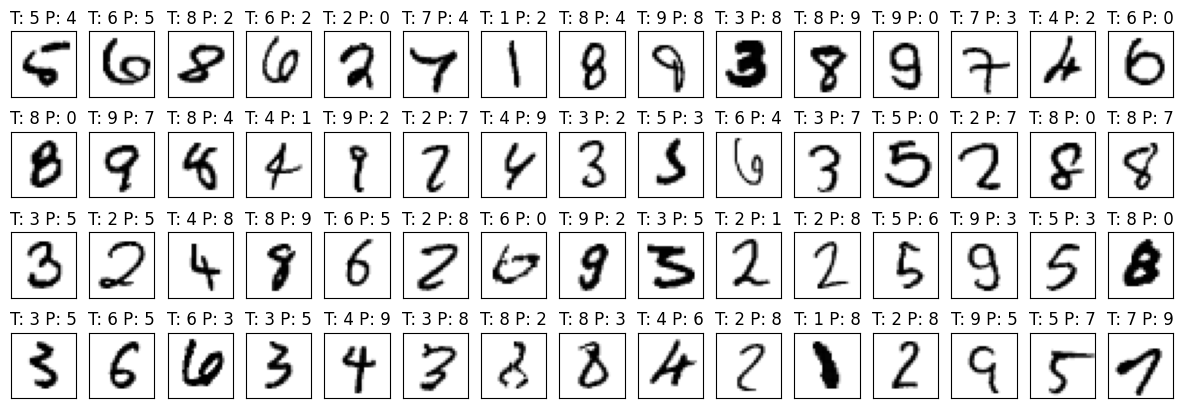

In [ ]:
fig, axis = plt.subplots(4, 15, figsize=[15, 5])
for X, y, y_p, ax in zip(X_test_innacurate[:60], y_test_innacurate[:60], y_pred_innacurate[:60], axis.ravel()):
  ax.imshow(X, cmap="binary")
  ax.set_title(f"T: {y} P: {y_p}")
  ax.set_xticks([])
  ax.set_yticks([])

# Regression

In [ ]:
class NeuralNetwork():
  def __init__(self, input_size, hidden_size, output_size):
    self.linear1 = Layer_Linear(input_size, hidden_size)
    self.relu1 = Activation_Relu()
    self.linear2 = Layer_Linear(hidden_size, hidden_size)
    self.relu2 = Activation_Relu()
    self.linear3 = Layer_Linear(hidden_size, output_size)

  def forward(self, X):
    self.z1 = self.linear1.forward(X)
    self.a1 = self.relu1.forward(self.z1)
    self.z2 = self.linear2.forward(self.a1)
    self.a2 = self.relu2.forward(self.z2)
    self.output = self.linear3.forward(self.a2)

  def backward(self, gradient):
    self.linear3.backward(gradient)
    self.relu2.backward(self.linear3.d_a)
    self.linear2.backward(self.relu2.d_z)
    self.relu1.backward(self.linear2.d_a)
    self.linear1.backward(self.relu1.d_z)

  def optimize(self, learning_rate):
    self.momentum1 = self.linear1.optimize(learning_rate)
    self.momentum2 = self.linear2.optimize(learning_rate)
    self.momentum3 = self.linear3.optimize(learning_rate)

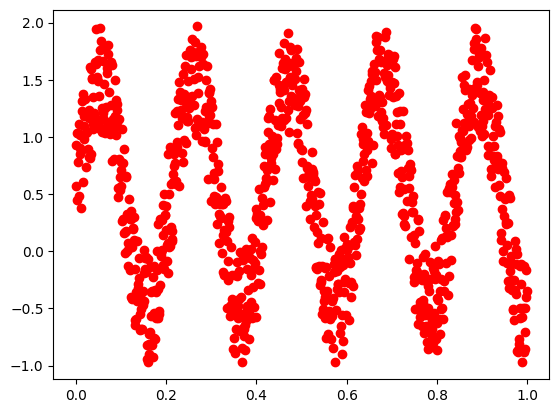

In [ ]:
X = np.arange(0, 1, 0.001).reshape(-1, 1)
y = np.sin(X * 30) + np.random.rand(1000, 1)
plt.plot(X[:, 0], y[:, 0], "ro");

In [ ]:
model = NeuralNetwork(1, 300, 1)
loss_fn = Loss_MSE()

Epoch: 1 Loss: 3508.49


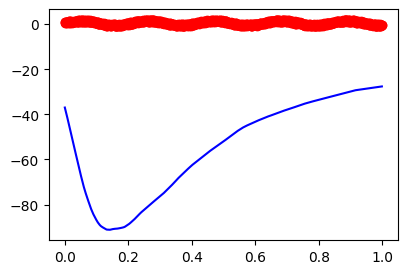

Epoch: 5001 Loss: 0.2027


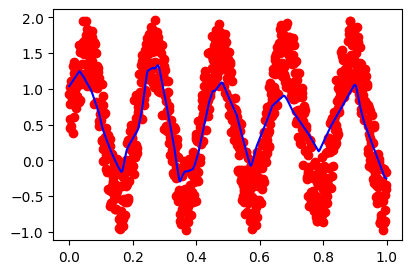

Epoch: 10001 Loss: 0.1763


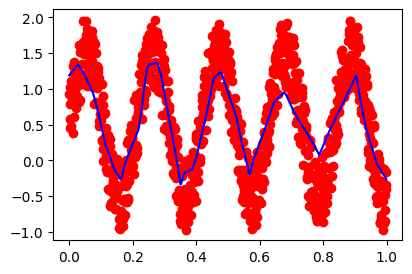

Epoch: 15001 Loss: 0.1624


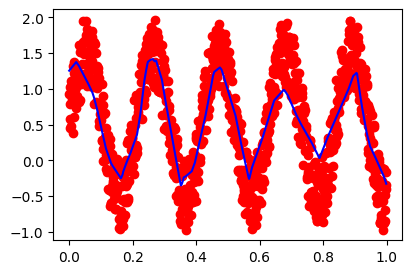

Epoch: 20001 Loss: 0.1537


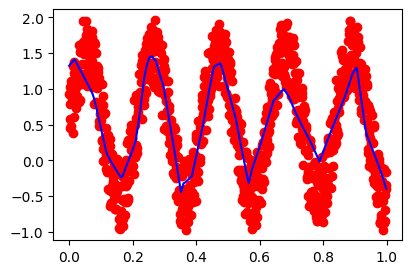

Epoch: 25001 Loss: 0.1461


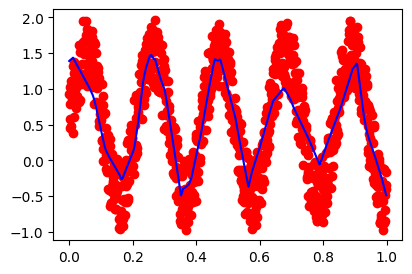

Epoch: 30001 Loss: 0.1373


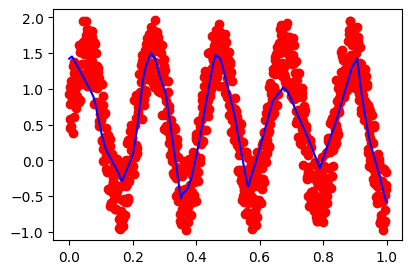

Epoch: 35001 Loss: 0.1316


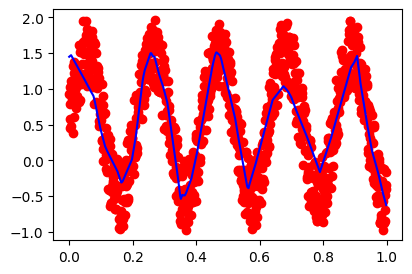

Epoch: 40001 Loss: 0.1271


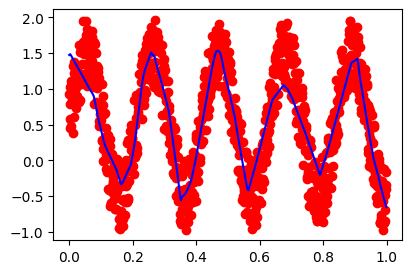

Epoch: 45001 Loss: 0.1233


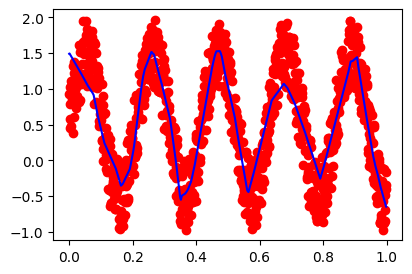

Epoch: 50001 Loss: 0.12


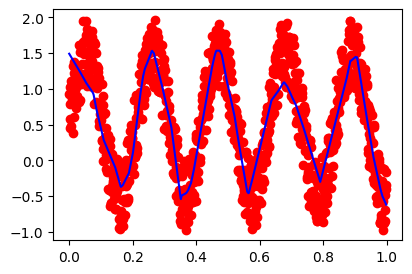

In [ ]:
for i in range(50001):
  model.forward(X)
  y_pred = model.output
  loss = loss_fn.forward(y, y_pred)
  d_loss = loss_fn.backward()
  model.backward(d_loss)
  model.optimize(0.000001)

  if i % 5000 == 0:
    model.forward(X)
    y_pred = model.output
    loss = loss_fn.forward(y, y_pred)
    print(f"Epoch: {i + 1} Loss: {round(loss, 4)}")
    plt.figure(figsize=(4.5, 3))
    plt.plot(X[:, 0], y[:, 0], "ro");
    plt.plot(X[:, 0], y_pred[:, 0], "b-");
    plt.show()